In [13]:
import os
import sys

sys.path.append(os.path.abspath(".."))

import polars as pl
from pathlib import Path


import os
import sys

sys.path.append(os.path.abspath(".."))

import polars as pl
from pathlib import Path
from src.utils.utils import welch_ttest_with_normality, bootstrap_ttest, mann_whitney_u_test

DATA_OUTPUT_PATH = Path("../data/results/")
DATA_OUTPUT_PATH.mkdir(parents=True, exist_ok=True)



In [24]:
import polars as pl

df = pl.read_parquet(DATA_OUTPUT_PATH / "all_experiments.parquet").filter(
    (pl.col("num_agents") > 1) & (pl.col("is_symmetric"))
).with_columns(
    (pl.col("chosen_price") / pl.col("alpha")).alias("price")
).select([
    "num_agents", "price", "agent_prefix_type", "round", "agent", "experiment_timestamp"
])

# Only last 50 rounds
df = df.filter(pl.col("round") > 250)


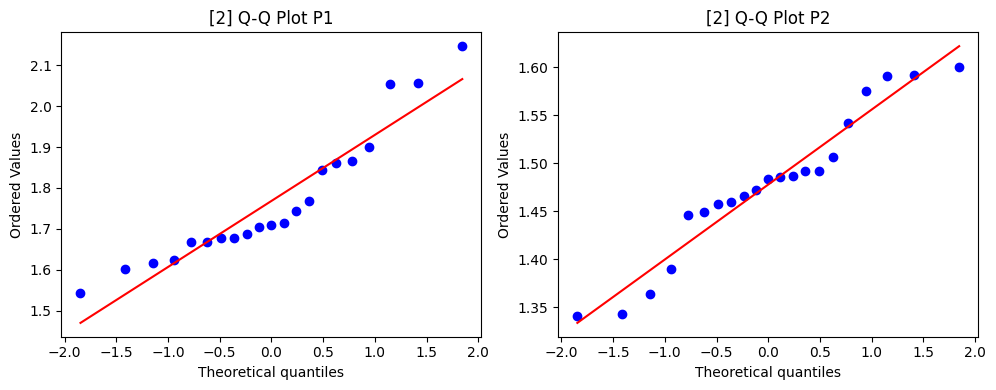

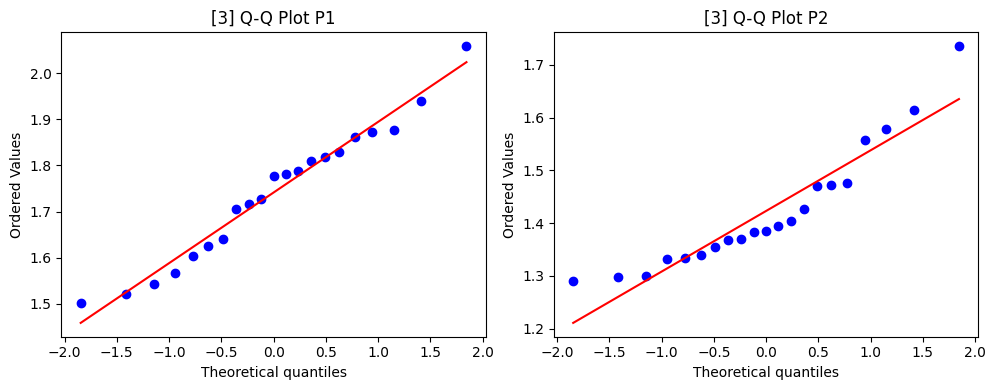

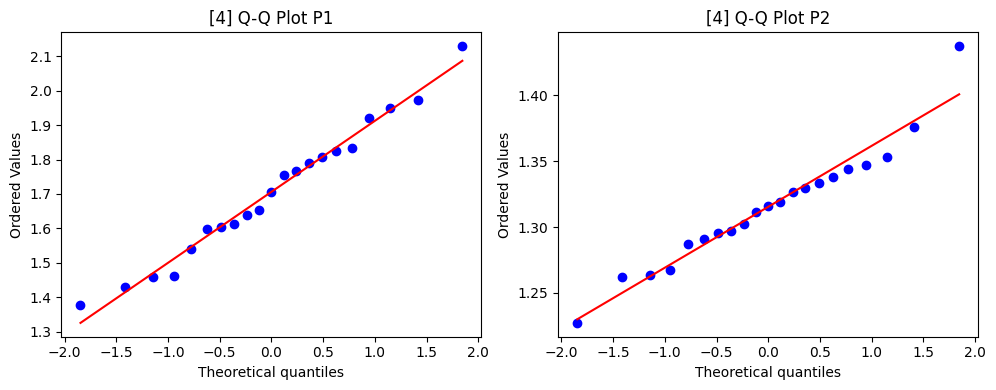

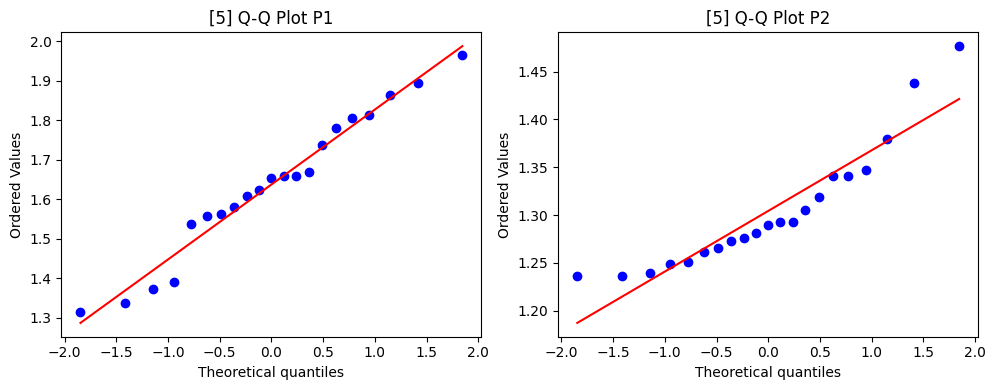

In [30]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import probplot

# Loop through market sizes
for n_agents in df["num_agents"].unique():
    df_n = df.filter(pl.col("num_agents") == n_agents)

    # Compute mean price per experiment and prompt
    agg_df = (
        df_n.group_by(["experiment_timestamp", "agent_prefix_type"])
        .agg(pl.col("price").mean().alias("mean_price"))
        .to_pandas()
    )

    # Separate by prompt
    p1_means = agg_df[agg_df["agent_prefix_type"] == "P1"]["mean_price"].tolist()
    p2_means = agg_df[agg_df["agent_prefix_type"] == "P2"]["mean_price"].tolist()

    # Build long-form DataFrame for Seaborn
    df_vis = pd.DataFrame({
        "price": p1_means + p2_means,
        "Prompt": ["P1"] * len(p1_means) + ["P2"] * len(p2_means)
    })

    ## Plot 4: Q-Q Plots
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    probplot(p1_means, dist="norm", plot=plt)
    plt.title(f"[{n_agents}] Q-Q Plot P1")

    plt.subplot(1, 2, 2)
    probplot(p2_means, dist="norm", plot=plt)
    plt.title(f"[{n_agents}] Q-Q Plot P2")
    plt.tight_layout()
    plt.show()


In [23]:
import polars as pl
from scipy.stats import ttest_ind

# Load and preprocess data
df = pl.read_parquet(DATA_OUTPUT_PATH / "all_experiments.parquet").filter(
    (pl.col("num_agents") > 1) & (pl.col("is_symmetric"))
).with_columns(
    (pl.col("chosen_price") / pl.col("alpha")).alias("price")
).select([
    "num_agents", "price", "agent_prefix_type", "round", "agent", "experiment_timestamp"
])

# Filter to last 50 rounds
df = df.filter(pl.col("round") > 250)

# Store results
results = []

# Loop through each market setting
for n_agents in df["num_agents"].unique():
    df_n = df.filter(pl.col("num_agents") == n_agents)

    # Get average price per experiment (across all firms), last 50 rounds
    agg_df = (
        df_n.group_by(["experiment_timestamp", "agent_prefix_type"])
        .agg(pl.col("price").mean().alias("mean_price"))
    )

    # Split by P1 and P2
    p1_means = agg_df.filter(pl.col("agent_prefix_type") == "P1")["mean_price"].to_list()
    p2_means = agg_df.filter(pl.col("agent_prefix_type") == "P2")["mean_price"].to_list()

    # Check if both groups have enough data
    if len(p1_means) > 1 and len(p2_means) > 1:
        stat, p_value = ttest_ind(p1_means, p2_means, equal_var=False)
        results.append({
            "num_agents": n_agents,
            "mean_P1": sum(p1_means) / len(p1_means),
            "mean_P2": sum(p2_means) / len(p2_means),
            "t_stat": stat,
            "p_value": p_value,
            "n_P1": len(p1_means),
            "n_P2": len(p2_means)
        })

# Optional: Print nicely
for r in results:
    print(f"Market with {r['num_agents']} agents:")
    print(f"  Mean P1: {r['mean_P1']:.3f} | Mean P2: {r['mean_P2']:.3f}")
    print(f"  Welch's t = {r['t_stat']:.3f}, p = {r['p_value']:.4f} (n1={r['n_P1']}, n2={r['n_P2']})\n")


Market with 2 agents:
  Mean P1: 1.768 | Mean P2: 1.478
  Welch's t = 7.423, p = 0.0000 (n1=21, n2=21)

Market with 3 agents:
  Mean P1: 1.741 | Mean P2: 1.423
  Welch's t = 7.774, p = 0.0000 (n1=21, n2=21)

Market with 4 agents:
  Mean P1: 1.706 | Mean P2: 1.315
  Welch's t = 8.820, p = 0.0000 (n1=21, n2=21)

Market with 5 agents:
  Mean P1: 1.637 | Mean P2: 1.304
  Welch's t = 7.859, p = 0.0000 (n1=21, n2=21)

